In [12]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

### dataframe dados escolares/esc_rmsp/relatórios

In [6]:
#abrindo os dados
dados_escolares = pd.read_csv('DadosEscolares1996-2015.csv', encoding = 'latin1')
esc_rmsp = pd.read_csv('ESC2013_RMSP_CEM.csv', encoding = 'latin1')
rendimento = pd.read_csv('RendimentoEscolar2000-2015.csv', encoding = 'latin1')
nota = pd.read_csv('ENEM2015.csv')
#agrupando por escolas
rendimento = rendimento.groupby('CODMEC').mean()
dados_escolares = dados_escolares.groupby('CODMEC').mean()
esc_rmsp = esc_rmsp.groupby('CODESC').mean()
#Apagando a classe desbalanceada
nota = nota[nota.Classificacao != 0]
#Alterando o nome da coluna de acordo com os outros dataframes
nota.rename(columns = {'CODIGO DA ENTIDADE':'CODMEC'}, inplace = True)
#Em todos Dataframes temos mais escolas do que o nosso target
dados_escolares = dados_escolares.reset_index()[dados_escolares.reset_index().CODMEC.isin(nota['CODMEC'])]
esc_rmsp = esc_rmsp.reset_index()[esc_rmsp.reset_index().CODESC.isin(nota['CODMEC'])]
esc_rmsp.rename(columns = {'CODESC': 'CODMEC'}, inplace = True)
rendimento = rendimento.reset_index()[rendimento.reset_index().CODMEC.isin(nota['CODMEC'])]
#apgando valores nulos
dados_escolares.drop(dados_escolares.columns[dados_escolares.isnull().mean() != 0], axis=1, inplace = True)
esc_rmsp.drop(esc_rmsp.columns[esc_rmsp.isnull().mean() >= 0.15], axis=1, inplace = True)
esc_rmsp.dropna(inplace = True, how = 'any')
def t(x):
    if x==0:
        return None
    else:
        return x
for c in rendimento.columns:
    rendimento[c] = rendimento[c].apply(t)
rendimento.drop(rendimento.columns[rendimento.isnull().mean() >= 0.15], axis=1, inplace = True)
rendimento.dropna(inplace = True, how = 'any')

In [11]:
print('\tshapes:')
print('dados_escolares: ', dados_escolares.shape)
print('esc_rmsp: ', esc_rmsp.shape)
print('rendimento: ', rendimento.shape)

	shapes:
dados_escolares:  (692, 212)
esc_rmsp:  (931, 52)
rendimento:  (365, 18)


### ridge regression na dados escolares

In [57]:
#criando o merge com base na coluna CODMEC usando o dataframe target e os dados escolares
new_df = pd.merge(dados_escolares, nota, on = 'CODMEC')
new_df.drop(['CODMEC', 'ANO','NUMERO DE PARTICIPANTES'], axis = 1, inplace = True)
#criando o data e o target
data = new_df.drop('Classificacao', axis = 1)
target = new_df.Classificacao
print(data.shape)
n_alphas = 200
alphas = np.logspace(-7, 2, n_alphas)

(692, 210)


In [92]:
def ridge_aplicada(data, target, alphas):
    coefs = []
    score = []
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    for val in alphas:
        ridge = Ridge(alpha = val)
        ridge.fit(data, target)
        coefs.append(ridge.coef_)
        score.append(ridge.score(data,target))
    
    features_values = list(zip(ridge.coef_,list(new_df.columns)))
    features_values.sort(reverse = True)
    
    
    #plot dos gráficos
    ax = plt.gca()

    ax.plot(alphas, coefs)
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel('alpha')
    plt.ylabel('weights')
    plt.title('Coeficientes com o uso do Ridge')
    plt.axis('tight')
    plt.show()
    
    ax = plt.gca()

    ax.plot(alphas, score)
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel('alpha')
    plt.ylabel('score')
    plt.title('Scores com o uso de Ridge')
    plt.axis('tight')
    plt.show()
    
    features_values = [(a,b) for (a,b) in features_values if a > 0.01]
    print('nº colunas: ', len(features_values))
    print(features_values)

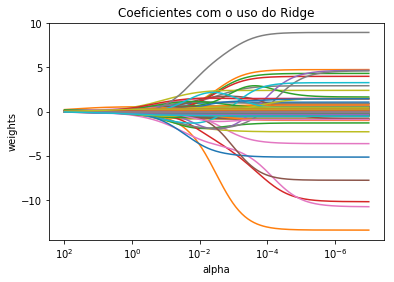

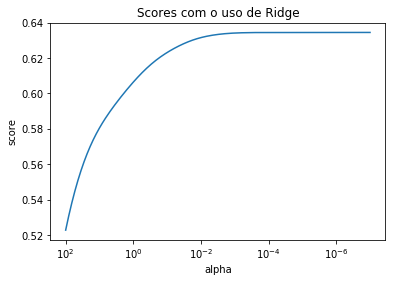

nº colunas:  43
[(0.2210644852975508, 'Qtde_Docentes'), (0.18560995765321134, 'NUM_FUNC'), (0.08962323621905427, 'ALE9F9S'), (0.06417600004170639, '6fund'), (0.04846951696224556, 'ALE9F8S'), (0.042933892257498635, 'ALE9F6A9'), (0.037030918933334815, 'EE_Down_PRE'), (0.035799169555279224, 'AL_CRECHE'), (0.03570885391052958, 'EE_Asperger_MED'), (0.03421969552136875, 'ALEDESP'), (0.03303409007229883, 'EE_FIS_CRE'), (0.03258537173946273, 'CLE9F1S'), (0.02990340846485003, '>6'), (0.02786972378208597, 'EE_VIS_EJA'), (0.027367351259763244, '6'), (0.027272146352769665, 'CLEF4S'), (0.027027763754844312, 'EE_MEN_CRE'), (0.025633067951337175, 'CLEF8S'), (0.025574921246809858, 'CLEM4S'), (0.023489673850587128, 'EE_BAUD_FUND'), (0.022846281501554922, 'TOT_EE_EJA'), (0.021687905007715755, 'EE_Autismo_EJA'), (0.02060357911521484, 'ALEM3S'), (0.019269897612216758, 'CLEM3S'), (0.018885478104720146, 'EE_Asperger_EJA'), (0.01848704156370702, 'EE_Down_MED'), (0.018457889731548608, 'ALE9F7S'), (0.017638399

In [93]:
ridge_aplicada(data, target, alphas)